In [1]:
## pip install seaborn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline



In [3]:
# Load data
data = pd.read_csv('crop_recommendation.csv')

In [4]:
data['label'].value_counts()

label
rice           2000
maize          2000
jute           2000
cotton         2000
coconut        2000
papaya         2000
orange         2000
apple          2000
muskmelon      2000
watermelon     2000
grapes         2000
mango          2000
banana         2000
pomegranate    2000
lentil         2000
blackgram      2000
mungbean       2000
mothbeans      2000
pigeonpeas     2000
kidneybeans    2000
chickpea       2000
coffee         2000
Name: count, dtype: int64

In [5]:
# Split data into features and labels
X = data.drop('label', axis=1)
y = data['label']

# Calculate the correlation matrix
correlation_matrix = X.corr().abs()

# Get the upper triangle of the correlation matrix
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool_))

# Find columns (features) to drop (those with a correlation greater than 0.85)
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

# Drop correlated columns
X = X.drop(X[to_drop], axis=1)

# Split the data into train (70%) and temp (30%)
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(X, y, test_size=0.30, random_state=0)

# Split the temp data into test (2/3 of 20%) and validation (1/3 of 20%)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=1/3, random_state=0)

# The resulting splits should be roughly 70-20-10
print("Training set size:", len(X_train_temp))
print("Testing set size:", len(X_test))
print("Validation set size:", len(X_val))

Training set size: 30800
Testing set size: 8800
Validation set size: 4400


In [6]:
# Random Forest
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=6, max_features=4, random_state=0)
clf_rf.fit(X_train_temp, y_train_temp)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(clf_rf, X, y, cv=5, scoring='accuracy')

# Print out the scores for each fold and average accuracy
print("Cross-validated accuracy scores for each fold:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("Standard Deviation of CV Accuracy:", cv_scores.std())

y_pred_rf = clf_rf.predict(X_test)
accuracy_score_rf = accuracy_score(y_test, y_pred_rf)

print("Random Forest Test accuracy:", accuracy_score_rf)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Binarize the labels
y_bin_test = label_binarize(y_test, classes=data['label'].unique())
y_bin_pred_rf = label_binarize(y_pred_rf, classes=data['label'].unique())
n_classes = y_bin_test.shape[1]

# # Compute macro-average ROC curve and ROC area for multi-class task
# fpr = dict()
# tpr = dict()
# roc_auc = dict()

# for i in range(n_classes):
#     fpr[i], tpr[i], _ = roc_curve(y_bin_test[:, i], y_bin_pred_rf[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# mean_tpr = np.zeros_like(all_fpr)
# for i in range(n_classes):
#     mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
# mean_tpr /= n_classes

# fpr["macro"] = all_fpr
# tpr["macro"] = mean_tpr
# roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# print("Random Forest Macro-average of ROC curve:", roc_auc["macro"])

# # Plot the ROC curve
# plt.figure()
# plt.plot(fpr["macro"], tpr["macro"],
#          label='macro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["macro"]),
#          color='navy', linestyle=':', linewidth=4)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic Curve for Random Forest')
# plt.legend(loc="lower right")
# plt.show()



Cross-validated accuracy scores for each fold: [0.94886364 0.94840909 0.94636364 0.94613636 0.94636364]
Mean CV Accuracy: 0.9472272727272728
Standard Deviation of CV Accuracy: 0.001162428350231282
Random Forest Test accuracy: 0.9790909090909091
Random Forest Classification Report:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00       417
      banana       1.00      1.00      1.00       402
   blackgram       0.98      0.99      0.99       394
    chickpea       1.00      1.00      1.00       423
     coconut       1.00      0.97      0.98       381
      coffee       1.00      1.00      1.00       411
      cotton       1.00      1.00      1.00       387
      grapes       1.00      1.00      1.00       375
        jute       1.00      0.71      0.83       406
 kidneybeans       1.00      1.00      1.00       389
      lentil       0.97      1.00      0.99       370
       maize       0.99      1.00      0.99       408
       mango   

In [7]:
# Naive Bayes
# Set var_smoothing parameter for regularization; you can adjust the value as needed
# Naive Bayes with regularization
var_smoothing_value = 1e-1
clf_nb = GaussianNB(var_smoothing=var_smoothing_value)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(clf_nb, X, y, cv=5, scoring='accuracy')

# Print out the scores for each fold and average accuracy
print("Cross-validated accuracy scores for each fold:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("Standard Deviation of CV Accuracy:", cv_scores.std())

# Fit the model with the training data and predict for the test set
clf_nb.fit(X_train_temp, y_train_temp)
y_pred_nb = clf_nb.predict(X_test)
accuracy_score_nb = accuracy_score(y_test, y_pred_nb)

# Print the Naive Bayes Classification Report
print("Naive Bayes Test accuracy:", accuracy_score_nb)
print(classification_report(y_test, y_pred_nb))

# Binarize the labels
y_bin_test = label_binarize(y_test, classes=data['label'].unique())
y_bin_pred_nb = label_binarize(y_pred_rf, classes=data['label'].unique())
n_classes = y_bin_test.shape[1]

# # For the ROC Curve for multi-class
# y_bin_test_nb = label_binarize(y_test, classes=data['label'].unique())
# y_bin_pred_nb = label_binarize(y_pred_nb, classes=data['label'].unique())
# n_classes_nb = y_bin_test_nb.shape[1]

# fpr_nb = dict()
# tpr_nb = dict()
# roc_auc_nb = dict()

# for i in range(n_classes_nb):
#     fpr_nb[i], tpr_nb[i], _ = roc_curve(y_bin_test_nb[:, i], y_bin_pred_nb[:, i])
#     roc_auc_nb[i] = auc(fpr_nb[i], tpr_nb[i])

# all_fpr_nb = np.unique(np.concatenate([fpr_nb[i] for i in range(n_classes_nb)]))
# mean_tpr_nb = np.zeros_like(all_fpr_nb)
# for i in range(n_classes_nb):
#     mean_tpr_nb += np.interp(all_fpr_nb, fpr_nb[i], tpr_nb[i])
# mean_tpr_nb /= n_classes_nb

# fpr_nb["macro"] = all_fpr_nb
# tpr_nb["macro"] = mean_tpr_nb
# roc_auc_nb["macro"] = auc(fpr_nb["macro"], tpr_nb["macro"])

# print("Naive Bayes Macro-average of ROC curve on Test Set:", roc_auc_nb["macro"])

# # Plot the ROC curve
# plt.figure()
# plt.plot(fpr_nb["macro"], tpr_nb["macro"],
#          label='macro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc_nb["macro"]),
#          color='navy', linestyle=':', linewidth=4)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic Curve for Naive Bayes')
# plt.legend(loc="lower right")
# plt.show()

Cross-validated accuracy scores for each fold: [0.95806818 0.95818182 0.95852273 0.95829545 0.95829545]
Mean CV Accuracy: 0.9582727272727272
Standard Deviation of CV Accuracy: 0.00015075567228889199
Naive Bayes Test accuracy: 0.9568181818181818
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00       417
      banana       1.00      1.00      1.00       402
   blackgram       0.86      0.96      0.90       394
    chickpea       1.00      1.00      1.00       423
     coconut       1.00      0.94      0.97       381
      coffee       1.00      0.99      0.99       411
      cotton       0.92      1.00      0.96       387
      grapes       1.00      1.00      1.00       375
        jute       0.78      1.00      0.88       406
 kidneybeans       0.88      1.00      0.94       389
      lentil       0.88      1.00      0.93       370
       maize       1.00      0.86      0.93       408
       mango       1.00      1.00      1.00       41

In [19]:
# Use pipeline to ensure that the data is scaled before applying SVM
clf_svm = make_pipeline(
    StandardScaler(), 
    SVC(gamma= 0.1, C=0.01, random_state=0) # Updated kernel and gamma
)

# Using the pipeline to fit and predict ensures that scaling is applied in each step of CV and prediction.
clf_svm.fit(X_train_temp, y_train_temp)

# Perform 5-fold cross-validation
cv_scores_svm = cross_val_score(clf_svm, X, y, cv=5, scoring='accuracy')

# Print out the scores for each fold and average accuracy for SVM
print("Cross-validated accuracy scores for each fold (SVM):", cv_scores_svm)
print("Mean CV Accuracy (SVM):", cv_scores_svm.mean())
print("Standard Deviation of CV Accuracy (SVM):", cv_scores_svm.std())

y_pred_svm = clf_svm.predict(X_test)
accuracy_score_svm = accuracy_score(y_test, y_pred_svm)

print("SVM Test accuracy:", accuracy_score_svm)
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

# Binarize the labels for SVM
y_bin_test = label_binarize(y_test, classes=data['label'].unique())
y_bin_pred_svm = label_binarize(y_pred_svm, classes=data['label'].unique())
n_classes = y_bin_test.shape[1]

# # Compute macro-average ROC curve and ROC area for multi-class task for SVM
# fpr_svm = dict()
# tpr_svm = dict()
# roc_auc_svm = dict()

# for i in range(n_classes):
#     fpr_svm[i], tpr_svm[i], _ = roc_curve(y_bin_test[:, i], y_bin_pred_svm[:, i])
#     roc_auc_svm[i] = auc(fpr_svm[i], tpr_svm[i])

# all_fpr_svm = np.unique(np.concatenate([fpr_svm[i] for i in range(n_classes)]))
# mean_tpr_svm = np.zeros_like(all_fpr_svm)
# for i in range(n_classes):
#     mean_tpr_svm += np.interp(all_fpr_svm, fpr_svm[i], tpr_svm[i])
# mean_tpr_svm /= n_classes

# fpr_svm["macro"] = all_fpr_svm
# tpr_svm["macro"] = mean_tpr_svm
# roc_auc_svm["macro"] = auc(fpr_svm["macro"], tpr_svm["macro"])

# print("SVM Macro-average of ROC curve:", roc_auc_svm["macro"])

# # Plot the ROC curve for SVM
# plt.figure()
# plt.plot(fpr_svm["macro"], tpr_svm["macro"],
#          label='macro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc_svm["macro"]),
#          color='green', linestyle=':', linewidth=4)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic Curve for SVM')
# plt.legend(loc="lower right")
# plt.show()

Cross-validated accuracy scores for each fold (SVM): [0.96113636 0.96       0.96125    0.96068182 0.96147727]
Mean CV Accuracy (SVM): 0.9609090909090909
Standard Deviation of CV Accuracy (SVM): 0.0005232211106009811
SVM Test accuracy: 0.9552272727272727
SVM Classification Report:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00       417
      banana       1.00      1.00      1.00       402
   blackgram       0.88      0.93      0.91       394
    chickpea       1.00      1.00      1.00       423
     coconut       0.98      1.00      0.99       381
      coffee       1.00      1.00      1.00       411
      cotton       0.99      1.00      0.99       387
      grapes       1.00      1.00      1.00       375
        jute       0.78      1.00      0.88       406
 kidneybeans       0.96      1.00      0.98       389
      lentil       0.83      0.94      0.88       370
       maize       1.00      0.99      1.00       408
       mango    

In [13]:


# Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_temp)
X_test_scaled = scaler.transform(X_test)

clf_lr = LogisticRegression(max_iter=10000, random_state=42)
clf_lr.fit(X_train_scaled, y_train_temp)
y_pred_lr = clf_lr.predict(X_test_scaled)
accuracy_score_lr = accuracy_score(y_test, y_pred_lr)

# XGBoost
warnings.filterwarnings("ignore", category=FutureWarning)

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train_temp)
y_test_encoded = encoder.transform(y_test)
clf_xgb = xgb.XGBClassifier(random_state=42)
clf_xgb.fit(X_train_temp, y_train_encoded)

y_pred_xgb_encoded = clf_xgb.predict(X_test)
y_pred_xgb = encoder.inverse_transform(y_pred_xgb_encoded)
accuracy_score_xgb = accuracy_score(y_test, y_pred_xgb)




In [14]:
# Accuracy Results
print("Random Forest Accuracy:", accuracy_score_rf)
print("Naive Bayes Accuracy:", accuracy_score_nb)
print("SVM Accuracy:", accuracy_score_svm)
print("Logistic Regression Accuracy (Scaled Data):", accuracy_score_lr)
print("XGBoost Accuracy:", accuracy_score_xgb)


Random Forest Accuracy: 0.9790909090909091
Naive Bayes Accuracy: 0.9568181818181818
SVM Accuracy: 0.9644318181818182
Logistic Regression Accuracy (Scaled Data): 0.9875
XGBoost Accuracy: 1.0


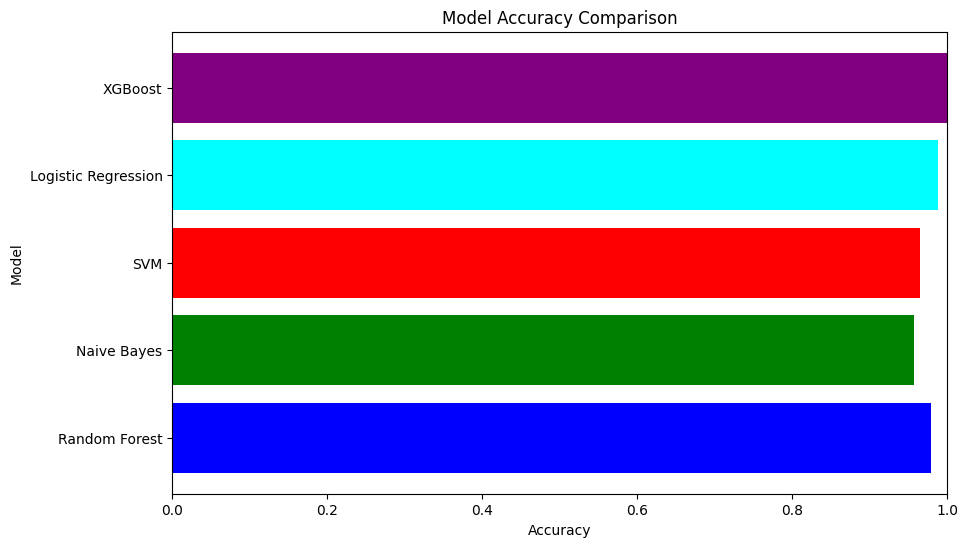

In [15]:


# Assuming you have stored the accuracies in the following manner:
model_names = ['Random Forest', 'Naive Bayes', 'SVM', 'Logistic Regression', 'XGBoost']
accuracies = [accuracy_score_rf, accuracy_score_nb, accuracy_score_svm, accuracy_score_lr, accuracy_score_xgb]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(model_names, accuracies, color=['blue', 'green', 'red', 'cyan', 'purple'])
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.title('Model Accuracy Comparison')
plt.xlim(0, 1)  # Assuming accuracy is a fraction. If it's in %, change to (0,100)
plt.show()